### Описание
Jupyter-notebook посвящен анализу производительности трёх алгоритмов для SSSP при условии того, что граф меняется. Граф не взвешенный (вес = 1).

### Постановка задачи
- [x] Сгенерить графы. Для генерации синтетических графов использовать библиотеку [NetworkX](https://networkx.org/documentation/stable/index.html). Использовать один из [генераторов для графов из области социальных сетей](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.social) и один [генератор для задач обнаружения сообществ](https://networkx.org/documentation/stable/reference/generators.html#module-networkx.generators.community). Генерировать графы, используя различные параметры генераторов, с количеством вершин 100, 1000, 5000, 10000, 25000, 50000, 100000.
- [x] Реализовать алгоритм Дейкстры. Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима, то значение соответствующей ячейки равно float('inf'). Добавить необходимые тесты.
- [x] Реализовать динамический вариант алгоритма Дейкстры, рассказанный на лекции по динамике (динамическое SSSP). Поддерживаемая структура - дерево кратчайших путей из вершины-источника. Должны быть написаны две функции: одна обновляет информацию о расстояниях в графе и дерево кратчайших путей (на вход подается список изменившихся рёбер), вторая функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Добавить необходимые тесты.
- [x] В качестве третьего алгоритма использовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford) из [Задачи 4].(https://github.com/gsvgit/high-performance-graph-analysis-course/blob/main/tasks/task4.md).
- [x] Сравнить суммарное время на все обновления (для всей пачки изменений). Для статических алгоритмов временем обновления считать полный пересчет кратчайших путей на новом графе. Количество изменившихся рёбер: 10%, 20%, 30%, 40% и 50% от общего числа рёбер в графе. Рёбра выбирать случайно. Следите за тем, чтобы пачка изменившихся рёбер для сравнения алгоритмов была одна и та же! Варианты сравнения следующие (отдельно для каждого количества вершин и процента изменившихся рёбер) :
  - [x] Инкрементальный вариант: граф изначально пустой, рёбра только добавляются.
  - [x] Декрементальный: рёбра только удаляются.
  - [x] Полный: половина из пачки рёбер удаляется, половина добавляется (действия должны чередоваться).
- [x] Сделать глубокомысленные выводы.

### Оборудование
Эксперимент проводился на ноутбуке ASUS VivoBook K510UN-BQ502 с процессором Intel® Core™ i5-8250U CPU @ 1.60GHz × 8, видеокартой GeForce MX150 и оперативной памятью DDR4 16ГБ (апгрейд на +8ГБ)

### Программное обеспечение
- Ubuntu 18.04LTS, 64-bit
- Python3.9

In [61]:
!lscpu
!/usr/local/cuda/bin/nvcc --version
!grep MemTotal /proc/meminfo

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               142
Model name:          Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz
Stepping:            10
CPU MHz:             797.597
CPU max MHz:         3400,0000
CPU min MHz:         400,0000
BogoMIPS:            3600.00
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            6144K
NUMA node0 CPU(s):   0-7
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sdbg

In [2]:
!pip3.9 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import networkx as nx
import random

import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:58) 
[GCC 7.5.0]


Сгенерируем синтетические графы с необходимым количеством вершин в каждой тестовой группе.

In [4]:
graphs = {100: [], 1000: [], 5000: [], 10000: [], 25000: [], 50000: [], 100000: []}

#small graphs
graphs[100].append(nx.karate_club_graph().to_directed())
graphs[100].append(nx.davis_southern_women_graph().to_directed())
graphs[100].append(nx.florentine_families_graph().to_directed())

print("Small graphs size (num of nodes):")
print(len(nx.karate_club_graph().to_directed().nodes))
print(len(nx.davis_southern_women_graph().to_directed().nodes))
print(len(nx.florentine_families_graph().to_directed().nodes))

group_nums = [40, 20, 10, 10]




for size in graphs.keys():
    if size == 100:
        continue
    
    in_group_probs = [0.15, 0.1, 0.05, 0.15]
    out_group_probs = [0.015, 0.005, 0.001, 0.015]
    
    group_sizes = [size // 40, size // 20, size // 10, size // 10]
    if size >= 25000:
        for i in range(len(in_group_probs)):
            in_group_probs[i] = in_group_probs[i] / 20 / 10
            
        for i in range(len(out_group_probs)):
            out_group_probs[i] = out_group_probs[i] / 100 / 50
    
        for i in range(4):

            graph = nx.generators.community.random_partition_graph([group_sizes[i]] * group_nums[i], in_group_probs[i], out_group_probs[i], directed=True)
            nx.write_gexf(graph, f"./generated/{size}_{group_nums[i]}_{in_group_probs[i]}.txt")
            graphs[size].append(f"./generated/{size}_{group_nums[i]}_{in_group_probs[i]}.txt")
        
    

Small graphs size (num of nodes):
34
32
15


In [5]:
# for size in graphs.keys():
#     if size == 100:
#         continue

#     for i in range(4):
#         temp = in_group_probs[i]
#         if size >= 25000:
#             temp = temp / 20
#         graphs[size].append(f"./generated/{size}_{group_nums[i]}_{temp}.txt")

In [6]:
print(graphs)

{100: [<networkx.classes.digraph.DiGraph object at 0x7f7c4d91ea60>, <networkx.classes.digraph.DiGraph object at 0x7f7c4d91ed60>, <networkx.classes.digraph.DiGraph object at 0x7f7c4d91eaf0>], 1000: [], 5000: [], 10000: [], 25000: ['./generated/25000_40_0.00075.txt', './generated/25000_20_0.0005.txt', './generated/25000_10_0.00025.txt', './generated/25000_10_0.00075.txt'], 50000: ['./generated/50000_40_0.00075.txt', './generated/50000_20_0.0005.txt', './generated/50000_10_0.00025.txt', './generated/50000_10_0.00075.txt'], 100000: ['./generated/100000_40_0.00075.txt', './generated/100000_20_0.0005.txt', './generated/100000_10_0.00025.txt', './generated/100000_10_0.00075.txt']}


In [7]:
import time
from pygraphblas import Matrix
from pygraphblas.types import FP64
from pathlib import Path
from project.shortest_path import single_source_bellman_ford
from project.dijkstra import dijkstra_sssp, DynamicSSSP
import itertools


small_results = Path("small.csv")
medium_results = Path("medium.csv")
large_results = Path("large.csv")

def measure_bellman_ford_sssp(graph, run_type, to_modify, start):
    if run_type == "inc":
        g = nx.DiGraph()
        g.add_nodes_from(graph.nodes)
        g.add_edges_from(to_modify)

    if run_type == "dec":
        g = nx.DiGraph(graph)
        g.remove_edges_from(to_modify)

    if run_type == "all":
        to_insert = to_modify[:len(to_modify) // 2]
        to_delete = to_modify[len(to_modify) // 2:]
        g = nx.DiGraph(graph)
        g.remove_edges_from(to_insert)

        for e_add, e_del in itertools.zip_longest(to_insert, to_delete):
            if e_add:
                g.add_edge(*e_add)
            if e_del:
                g.remove_edge(*e_del)


    graph_mat = Matrix.from_scipy_sparse(nx.to_scipy_sparse_array(g).astype(float, copy=False))
    graph_mat.eadd(Matrix.identity(FP64, graph_mat.nrows, value=0), out=graph_mat)
    
    start_idx = list(graph).index(start)
    
    t_start = time.perf_counter()
    ans = single_source_bellman_ford(graph_mat, start_idx)
    t_end = time.perf_counter()

    return t_end - t_start, ans


def measure_dijkstra_sssp(graph, run_type, to_modify, start):
    if run_type == "inc":
        g = nx.DiGraph()
        g.add_nodes_from(graph.nodes)
        g.add_edges_from(to_modify)

    if run_type == "dec":
        g = nx.DiGraph(graph)
        g.remove_edges_from(to_modify)

    if run_type == "all":
        to_insert = to_modify[:len(to_modify) // 2]
        to_delete = to_modify[len(to_modify) // 2:]
        g = nx.DiGraph(graph)
        g.remove_edges_from(to_insert)

        for e_add, e_del in itertools.zip_longest(to_insert, to_delete):
            if e_add:
                g.add_edge(*e_add)
            if e_del:
                g.remove_edge(*e_del)

    t_start = time.perf_counter()
    ans = dijkstra_sssp(g, start)
    t_end = time.perf_counter()
    return t_end - t_start, ans

def measure_dynamic_sssp(graph, run_type, to_modify, start):
    if run_type == "inc":
        g = nx.DiGraph()
        g.add_nodes_from(graph.nodes)

        algo = DynamicSSSP(g, start)

        for e in to_modify:
            algo.insert_edge(*e)
        
    if run_type == "dec":
        g = nx.DiGraph(graph)
        algo = DynamicSSSP(g, start)

        for e in to_modify:
            algo.delete_edge(*e)
        
    if run_type == "all":
        to_insert = to_modify[:len(to_modify) // 2]
        to_delete = to_modify[len(to_modify) // 2:]

        g = nx.DiGraph(graph)
        g.remove_edges_from(to_insert)

        algo = DynamicSSSP(g, start)

        for e_add, e_del in itertools.zip_longest(to_insert, to_delete):
            if e_add:
                algo.insert_edge(*e_add)
            if e_del:
                algo.delete_edge(*e_del)

    t_start = time.perf_counter()
    ans = algo.query_distances()
    t_end = time.perf_counter()
    
    return t_end - t_start, ans

def write_algo_result(file, algo, run_type, size, modified_percent, group_idx, time):
    with open(file, 'a') as f:
        f.write(f"{algo};{run_type};{size};{group_idx};{modified_percent};{time}\n")

/home/jexez/.local/lib/python3.9/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


import sources directory


In [8]:
import random

modified_edges_percent = [0.1, 0.2, 0.3, 0.4, 0.5]

def run(graph, percent, group_idx, run_type):
    start = random.sample(list(graph.nodes), 1)[0]
    to_modify = random.sample(list(graph.edges), int(graph.number_of_nodes() * percent))

    # inc
    t_dijkstra, ans1 = measure_dijkstra_sssp(graph, run_type, to_modify, start)
    t_bellman, ans2 = measure_bellman_ford_sssp(graph, run_type, to_modify, start)
    t_dynamic, ans3 = measure_dynamic_sssp(graph, run_type, to_modify, start)
    
    write_to = medium_results
    if graph.number_of_nodes() >= 25000:
        write_to = large_results
    elif graph.number_of_nodes() <= 100:
        write_to = small_results

    write_algo_result(write_to, 'dijkstra', run_type, size, percent, group_idx, t_dijkstra)
    write_algo_result(write_to, 'dynamic', run_type, size, percent, group_idx, t_dynamic)
    write_algo_result(write_to, 'bellman', run_type, size, percent, group_idx, t_bellman)
    
    # DEBUG
    return ans1, ans2, ans3

for percent in modified_edges_percent:
    for size in graphs.keys():
        
        if size == 100:
            pass
#             for graph in graphs[size]:
#                 run(graph, percent, -1, 'dec')
#                 run(graph, percent, -1, 'inc')
#                 run(graph, percent, -1, 'all')
#                 g_nodes = list(graph.nodes)
#                 bellman_res = {g_nodes[i]: d for i, d in enumerate(bellman)}
#                 print(dijkstra == dynamic)
#                 print(bellman_res == dynamic)

        elif size < 25000:
            pass
#             for i in range(4):
#                 graph = nx.read_gexf(graphs[size][i])
#                 dijkstra, bellman,dynamic = run(graph, percent, i, 'dec')
#                 run(graph, percent, i, 'inc')
#                 run(graph, percent, i, 'all')
                
#                 g_nodes = list(graph.nodes)
#                 bellman_res = {g_nodes[i]: d for i, d in enumerate(bellman)}
#                 print(dijkstra == dynamic)
#                 print(bellman_res == dynamic)
        else:
#             pass
            for i in range(4):
                    graph = nx.read_gexf(graphs[size][i])
                    run(graph, percent, i, 'dec')
                    run(graph, percent, i, 'inc')
                    run(graph, percent, i, 'all')
    

Finish on 1/25000 iteration (finish/max).
Finish on 1/25000 iteration (finish/max).
Finish on 0/25000 iteration (finish/max).
Finish on 4/25000 iteration (finish/max).
Finish on 0/25000 iteration (finish/max).
Finish on 0/25000 iteration (finish/max).
Finish on 1/25000 iteration (finish/max).
Finish on 0/25000 iteration (finish/max).
Finish on 0/25000 iteration (finish/max).
Finish on 0/25000 iteration (finish/max).
Finish on 0/25000 iteration (finish/max).
Finish on 30/25000 iteration (finish/max).
Finish on 0/50000 iteration (finish/max).
Finish on 0/50000 iteration (finish/max).
Finish on 0/50000 iteration (finish/max).
Finish on 109/50000 iteration (finish/max).
Finish on 0/50000 iteration (finish/max).
Finish on 1/50000 iteration (finish/max).
Finish on 2/50000 iteration (finish/max).
Finish on 1/50000 iteration (finish/max).
Finish on 0/50000 iteration (finish/max).
Finish on 15/50000 iteration (finish/max).
Finish on 0/50000 iteration (finish/max).
Finish on 15/50000 iteration (

Для проверки корректности алгоритмов во время тестовых запусков выполнялась попарная проверка результатов алгоритмов друг с другом
print(dijkstra == dynamic)

print(bellman_res == dynamic)

С первыми выбранными параметрами "наугад" (in_group_probs = [0.15, 0.1, 0.05, 0.15] / 20,
out_group_probs = [0.015, 0.005, 0.001, 0.015] / 100) не получилось завершить эксперимент для графов с 25к+ вершин. sudo htop показывал 100% загрузку оперативки (16гб) и 8гб swap'а.
Поэтому были уменьшены вероятности ребер в 10 и 50 раз соответственно и выполнены прогоны снова.

### Визуализируем полученные замеры

In [25]:
import pandas as pd
small = pd.read_csv(small_results, names=["Algorithm", "Type", "Number of vertices", "Group", "Modified percent", "Time(s)"], sep=";")
small

,Algorithm,Type,Number of vertices,Group,Modified percent,Time(s)
0,dijkstra,dec,100,-1,0.1,0.000153
1,dynamic,dec,100,-1,0.1,0.001756
2,bellman,dec,100,-1,0.1,0.000862
3,dijkstra,inc,100,-1,0.1,0.000039
4,dynamic,inc,100,-1,0.1,0.000046
...,...,...,...,...,...,...
130,dynamic,inc,100,-1,0.5,0.000041
131,bellman,inc,100,-1,0.5,0.000199
132,dijkstra,all,100,-1,0.5,0.000045
133,dynamic,all,100,-1,0.5,0.000225


In [17]:
small['Algorithm']

0      dijkstra
1       dynamic
2       bellman
3      dijkstra
4       dynamic
         ...   
130     dynamic
131     bellman
132    dijkstra
133     dynamic
134     bellman
Name: Algorithm, Length: 135, dtype: object

In [12]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns

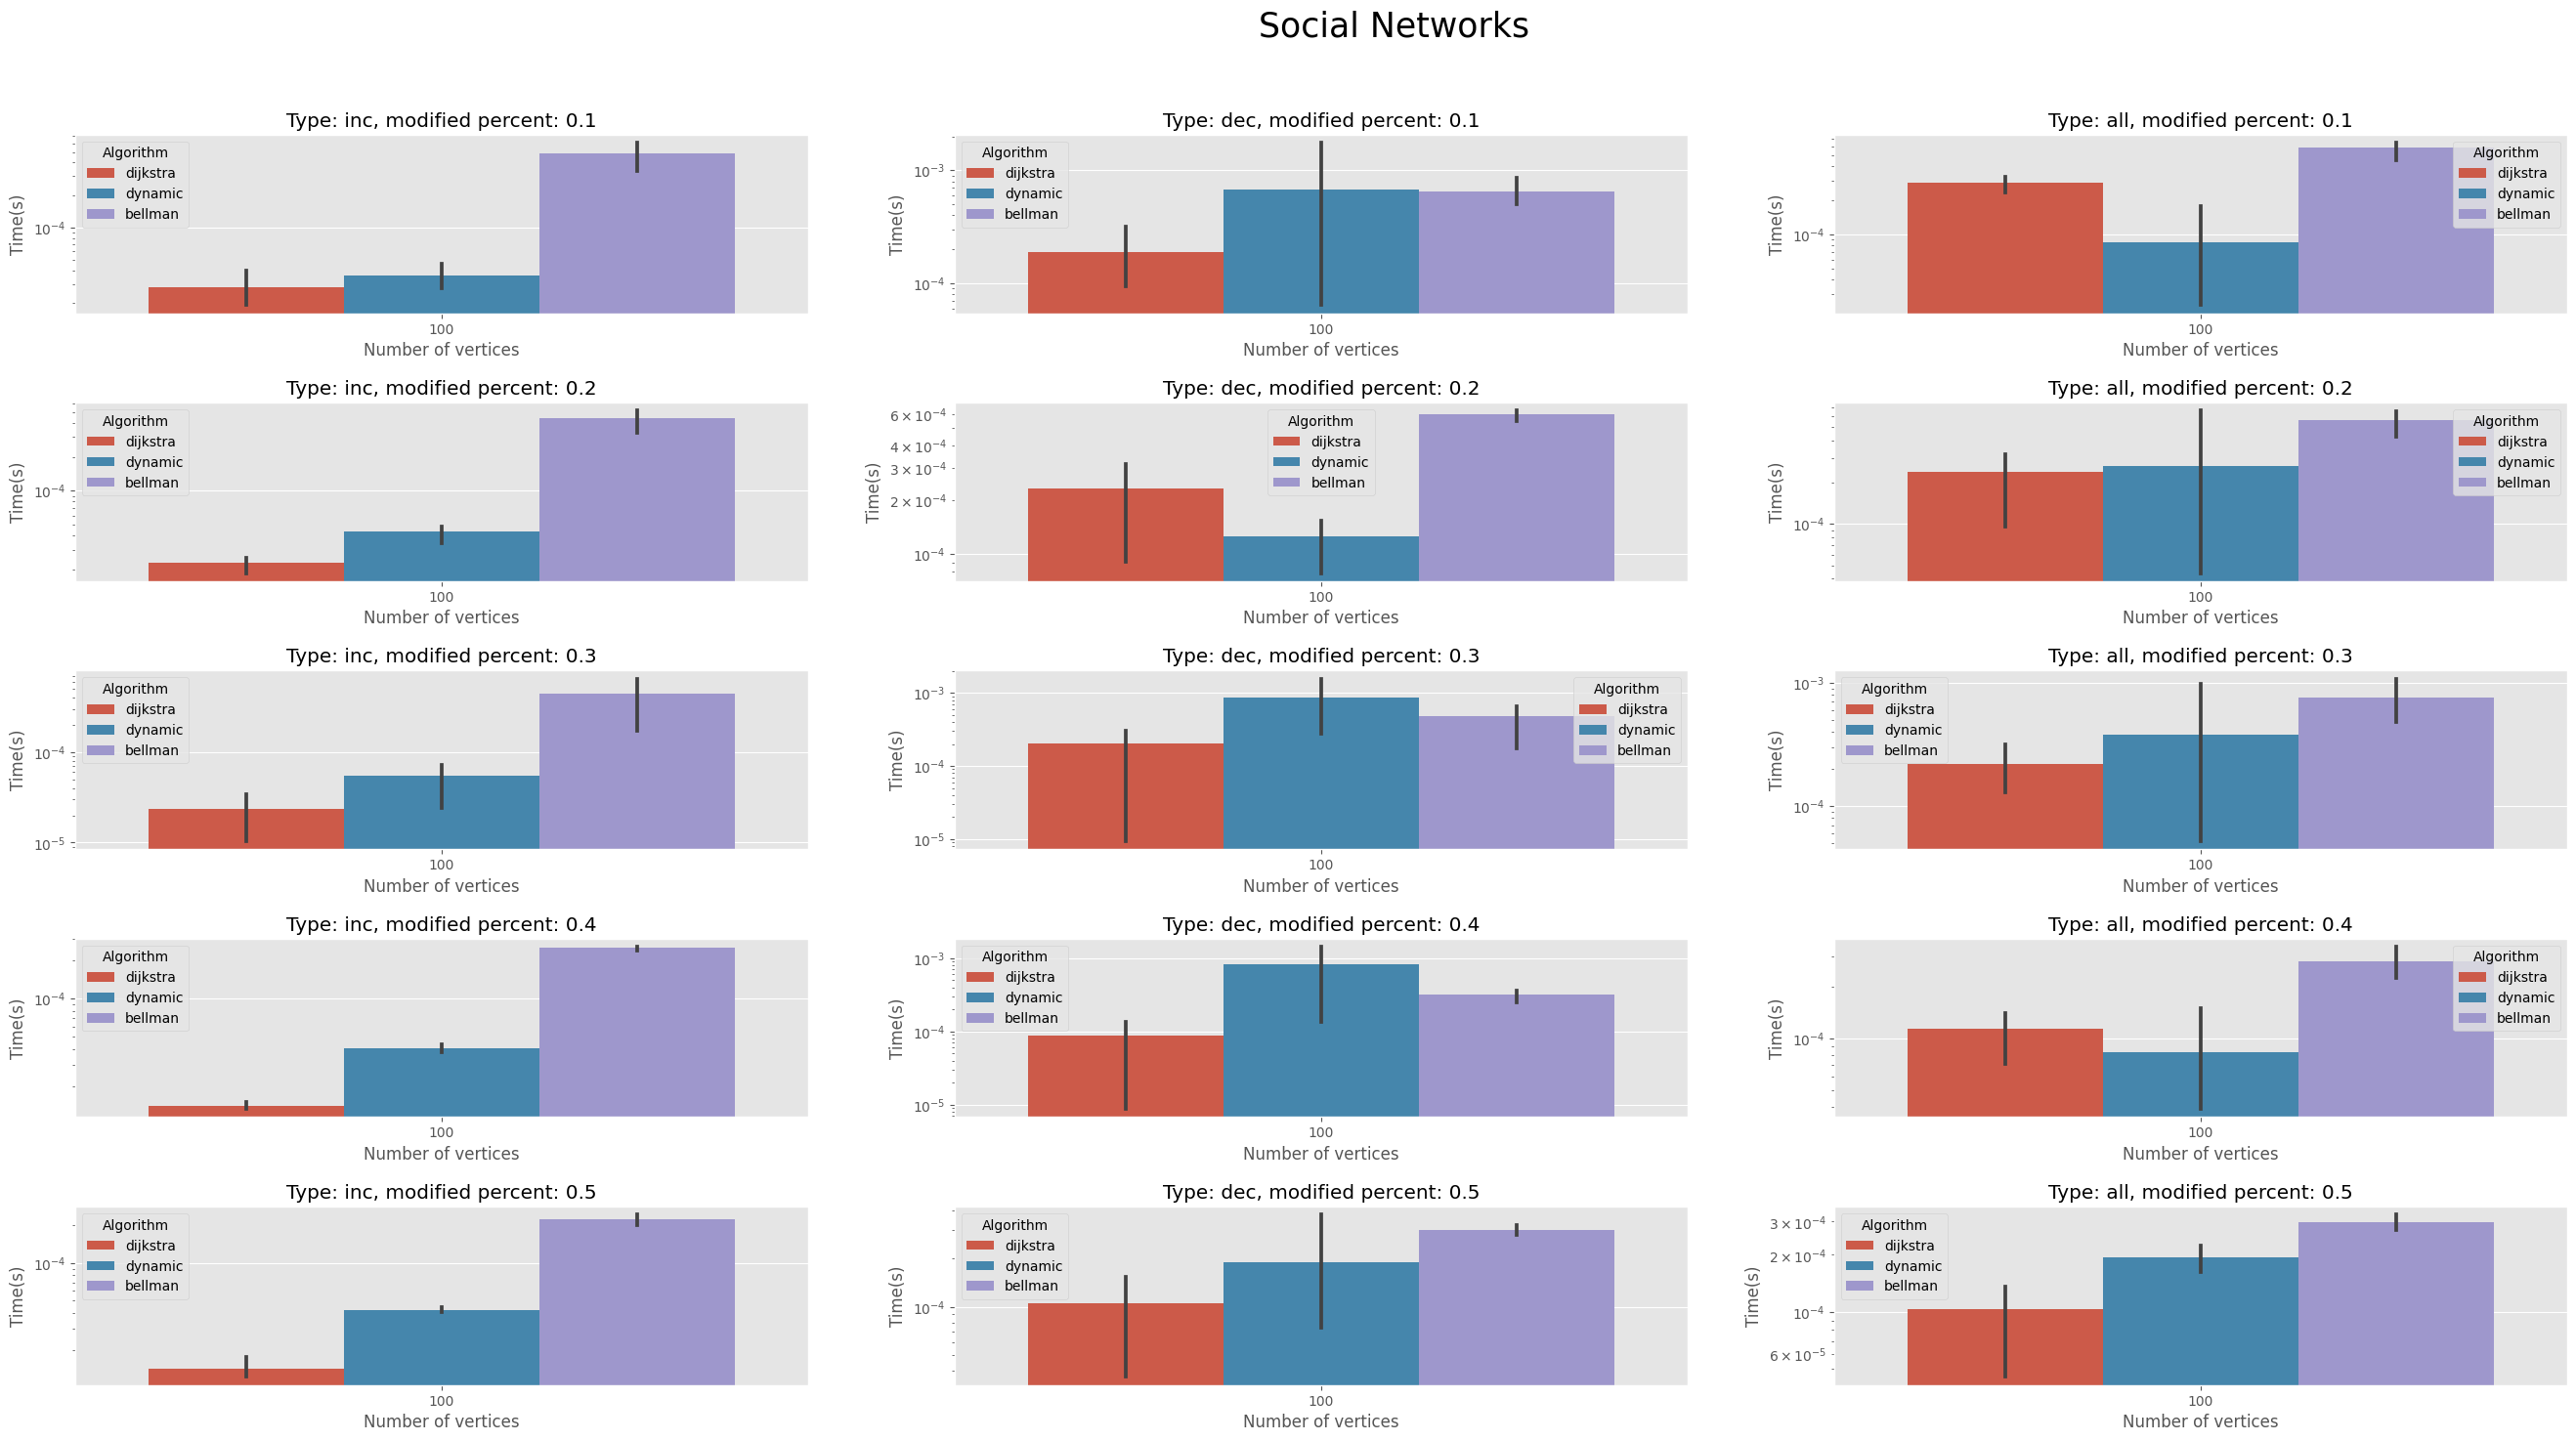

In [57]:
def show_plots(results, title):
    fig, axes = plt.subplots(len(modified_edges_percent), 3, figsize=(30,16))
    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    fig.suptitle(title, fontsize=25)
    
    i = 0
    for perc in modified_edges_percent:
        g = sns.barplot(ax=axes[i // 3, i % 3], x="Number of vertices", y="Time(s)", hue='Algorithm', data=results[(results['Type'] == "inc") & (results['Modified percent'] == perc)])
        g.set_title(f"Type: inc, modified percent: {perc}")
        g.set_yscale('log')
        i += 1
        g = sns.barplot(ax=axes[i // 3, i % 3], x="Number of vertices", y="Time(s)", hue='Algorithm', data=results[(results['Type'] == "dec") & (results['Modified percent'] == perc)])
        g.set_title(f"Type: dec, modified percent: {perc}")
        g.set_yscale('log')
        i += 1
        g = sns.barplot(ax=axes[i // 3, i % 3], x="Number of vertices", y="Time(s)", hue='Algorithm', data=results[(results['Type'] == "all") & (results['Modified percent'] == perc)])
        g.set_title(f"Type: all, modified percent: {perc}")
        g.set_yscale('log')
        i += 1
        

    plt.show()
    
show_plots(small, "Social Networks")

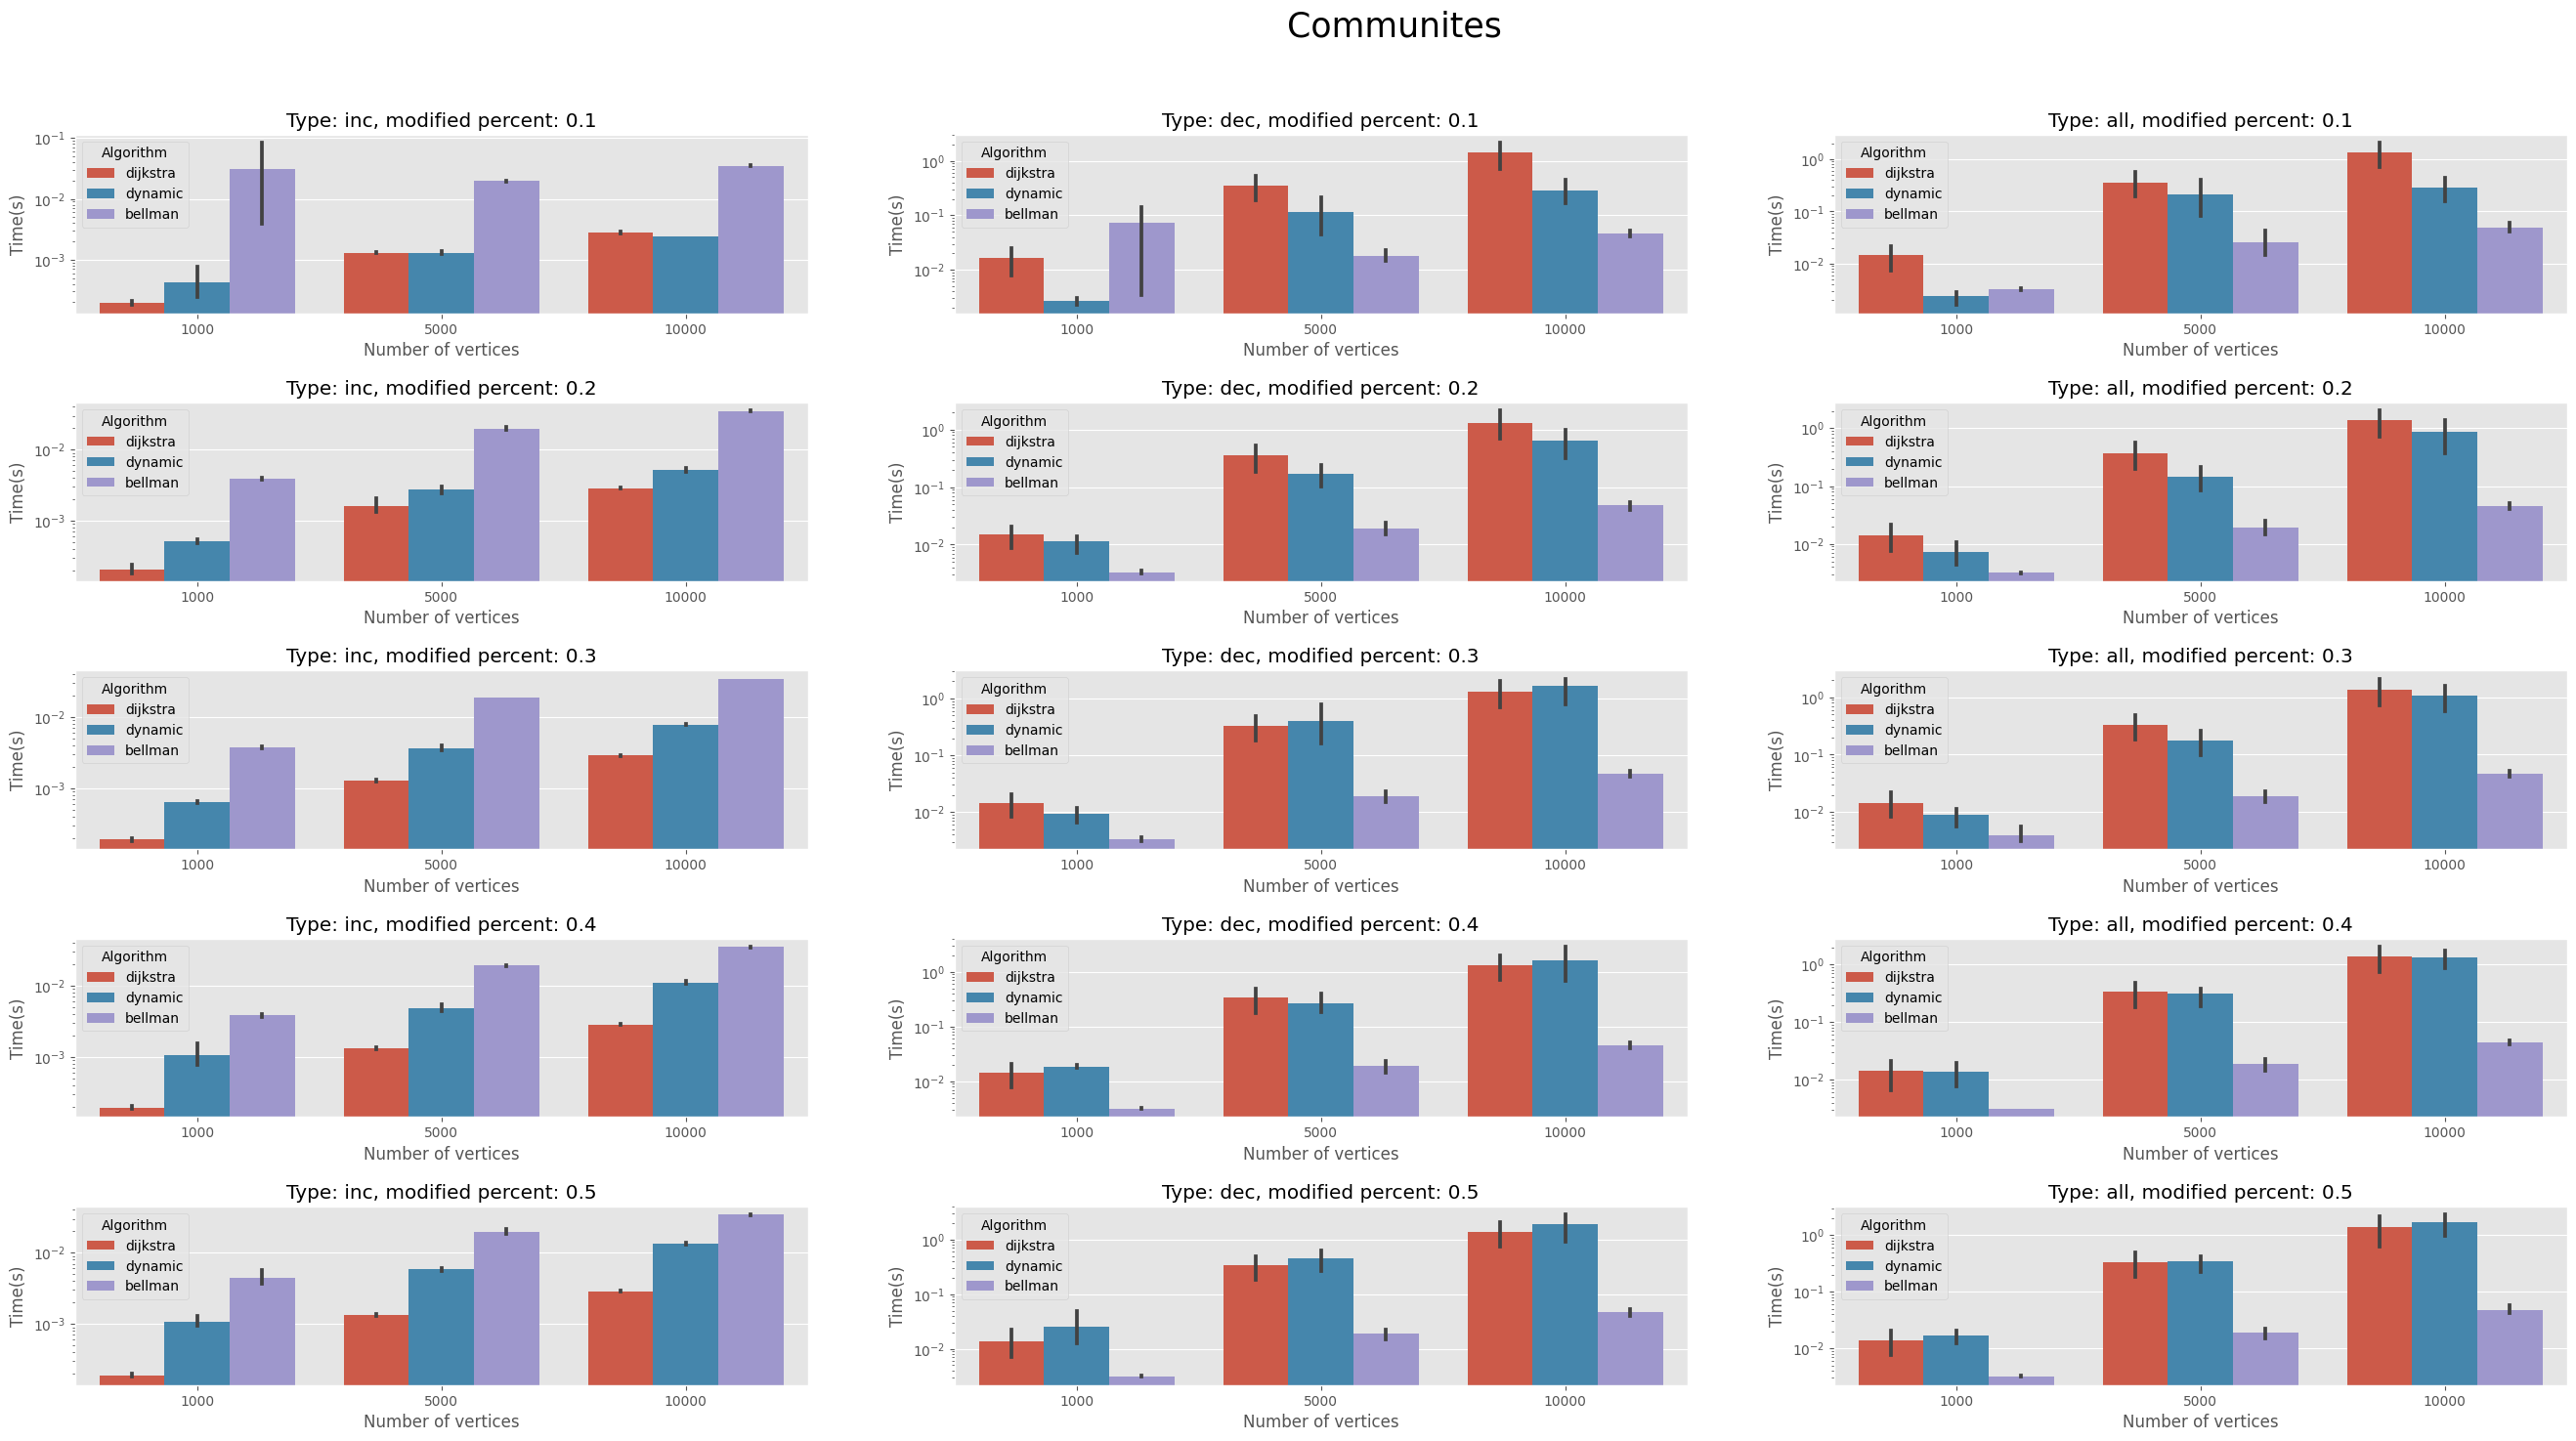

In [50]:
medium = pd.read_csv(medium_results, names=["Algorithm", "Type", "Number of vertices", "Group", "Modified percent", "Time(s)"], sep=";")
show_plots(medium, "Communites")

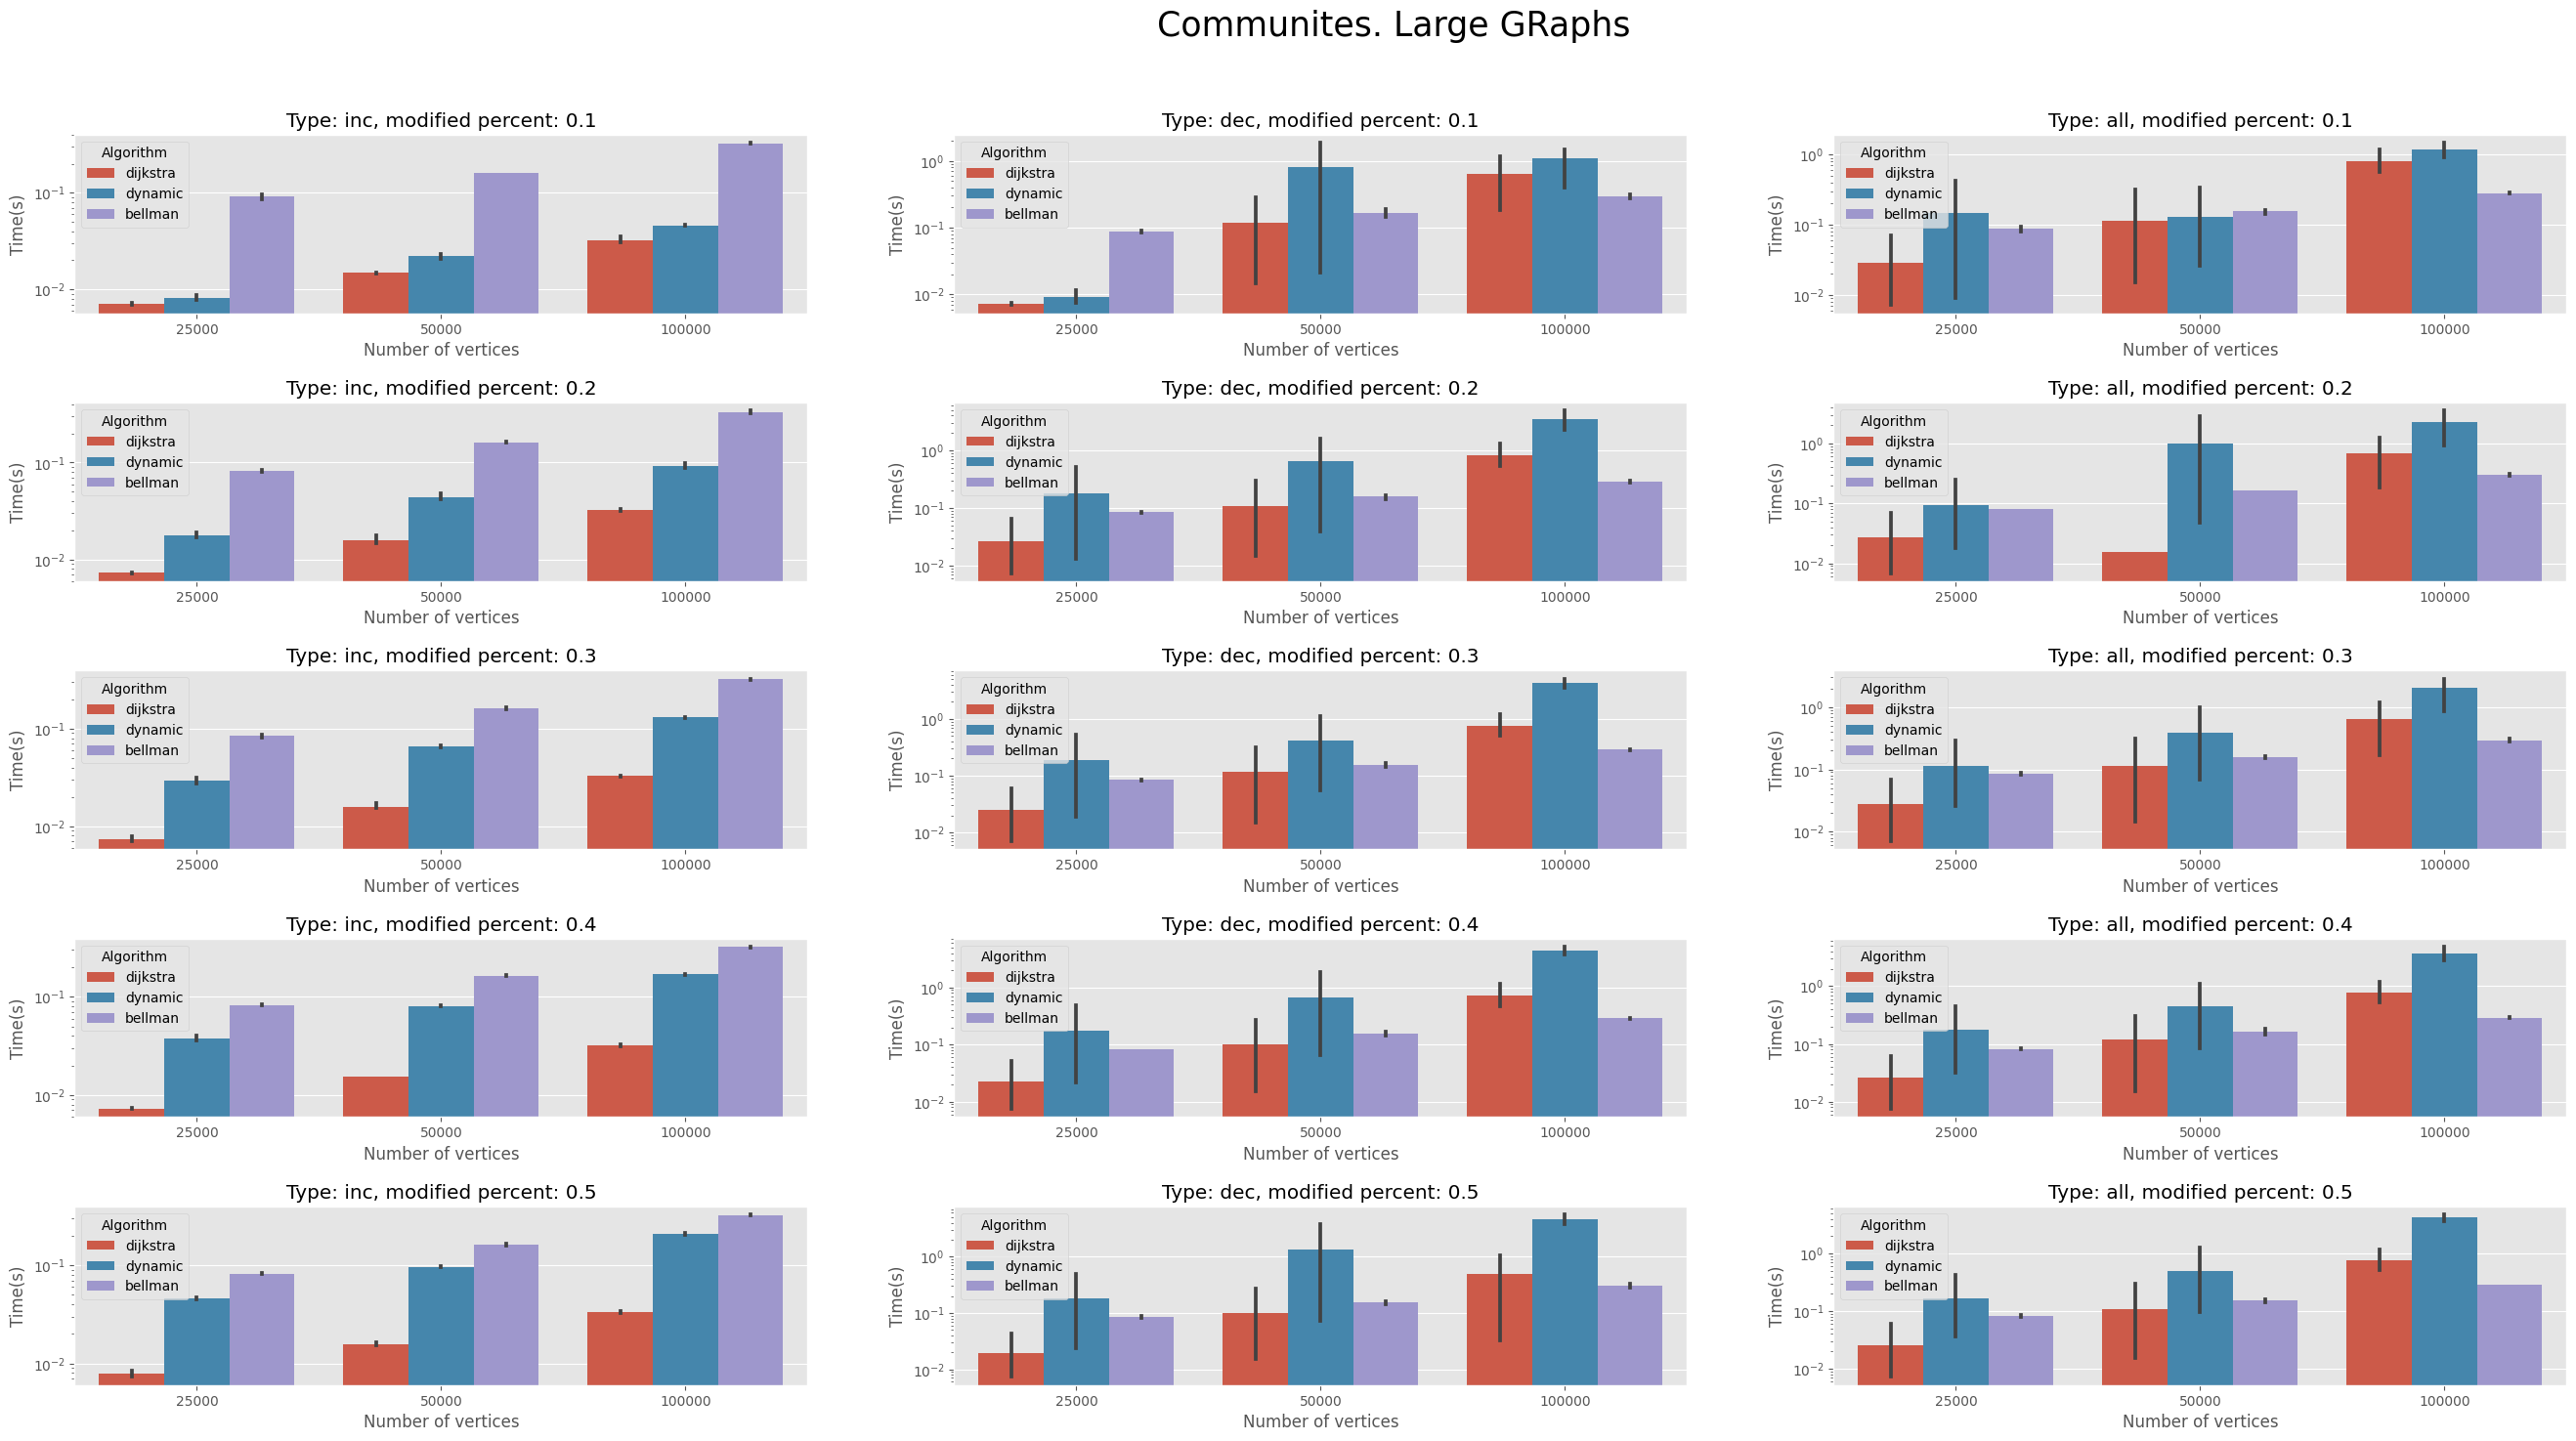

In [52]:
large = pd.read_csv(large_results, names=["Algorithm", "Type", "Number of vertices", "Group", "Modified percent", "Time(s)"], sep=";")
show_plots(large, "Communites. Large GRaphs")

In [53]:
large[large['Group'] == 0]

,Algorithm,Type,Number of vertices,Group,Modified percent,Time(s)
0,dijkstra,dec,25000,0,0.1,0.007039
1,dynamic,dec,25000,0,0.1,0.007146
2,bellman,dec,25000,0,0.1,0.081721
3,dijkstra,inc,25000,0,0.1,0.007378
4,dynamic,inc,25000,0,0.1,0.008133
...,...,...,...,...,...,...
508,dynamic,inc,100000,0,0.5,0.203457
509,bellman,inc,100000,0,0.5,0.319632
510,dijkstra,all,100000,0,0.5,0.481174
511,dynamic,all,100000,0,0.5,3.586061


In [54]:
large[large['Group'] == 3]

,Algorithm,Type,Number of vertices,Group,Modified percent,Time(s)
27,dijkstra,dec,25000,3,0.1,0.007663
28,dynamic,dec,25000,3,0.1,0.013037
29,bellman,dec,25000,3,0.1,0.088365
30,dijkstra,inc,25000,3,0.1,0.007063
31,dynamic,inc,25000,3,0.1,0.007577
...,...,...,...,...,...,...
535,dynamic,inc,100000,3,0.5,0.216668
536,bellman,inc,100000,3,0.5,0.321439
537,dijkstra,all,100000,3,0.5,1.381175
538,dynamic,all,100000,3,0.5,4.729931


Для эксперимента сравнил время работы алгоритмов на больших графах в нулевой и третьей группах. Параметры в них при генерации графов использовались одни и те же, за исключением того, что в нулевой группе 40 сообществ, а в третьей 10.

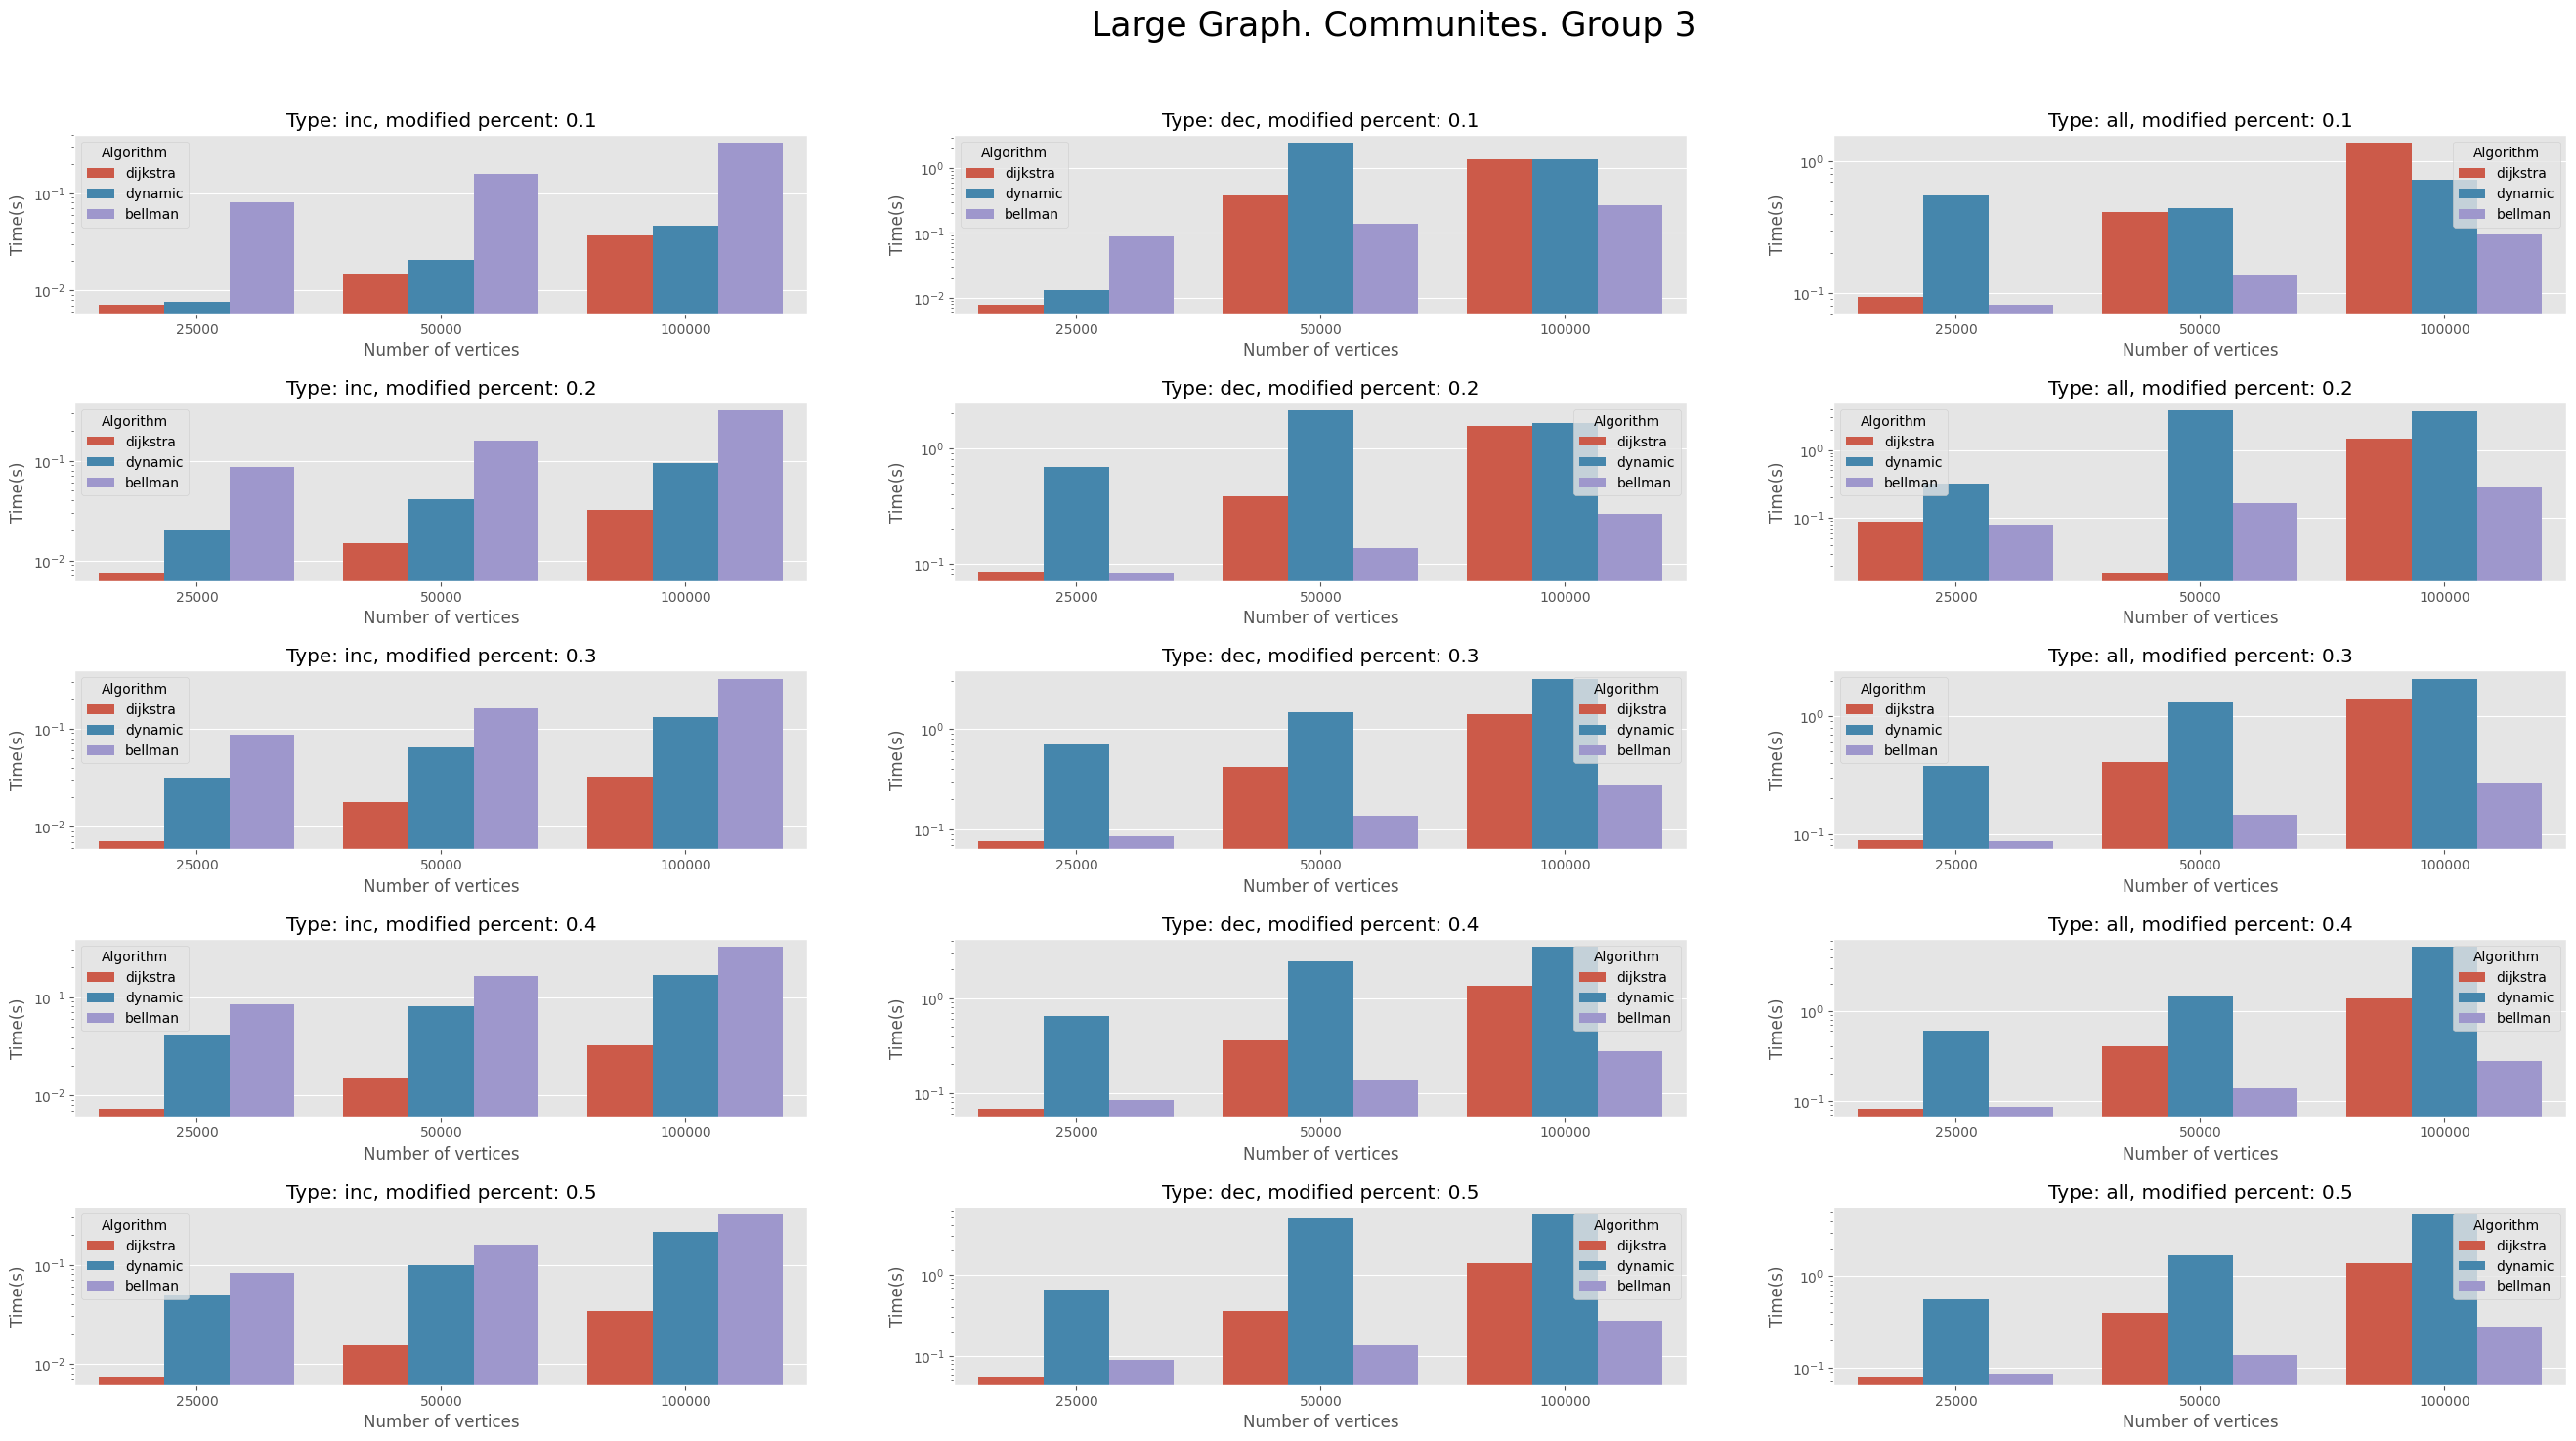

In [59]:
show_plots(large[large['Group'] == 3], "Large Graph. Communites. Group 3")

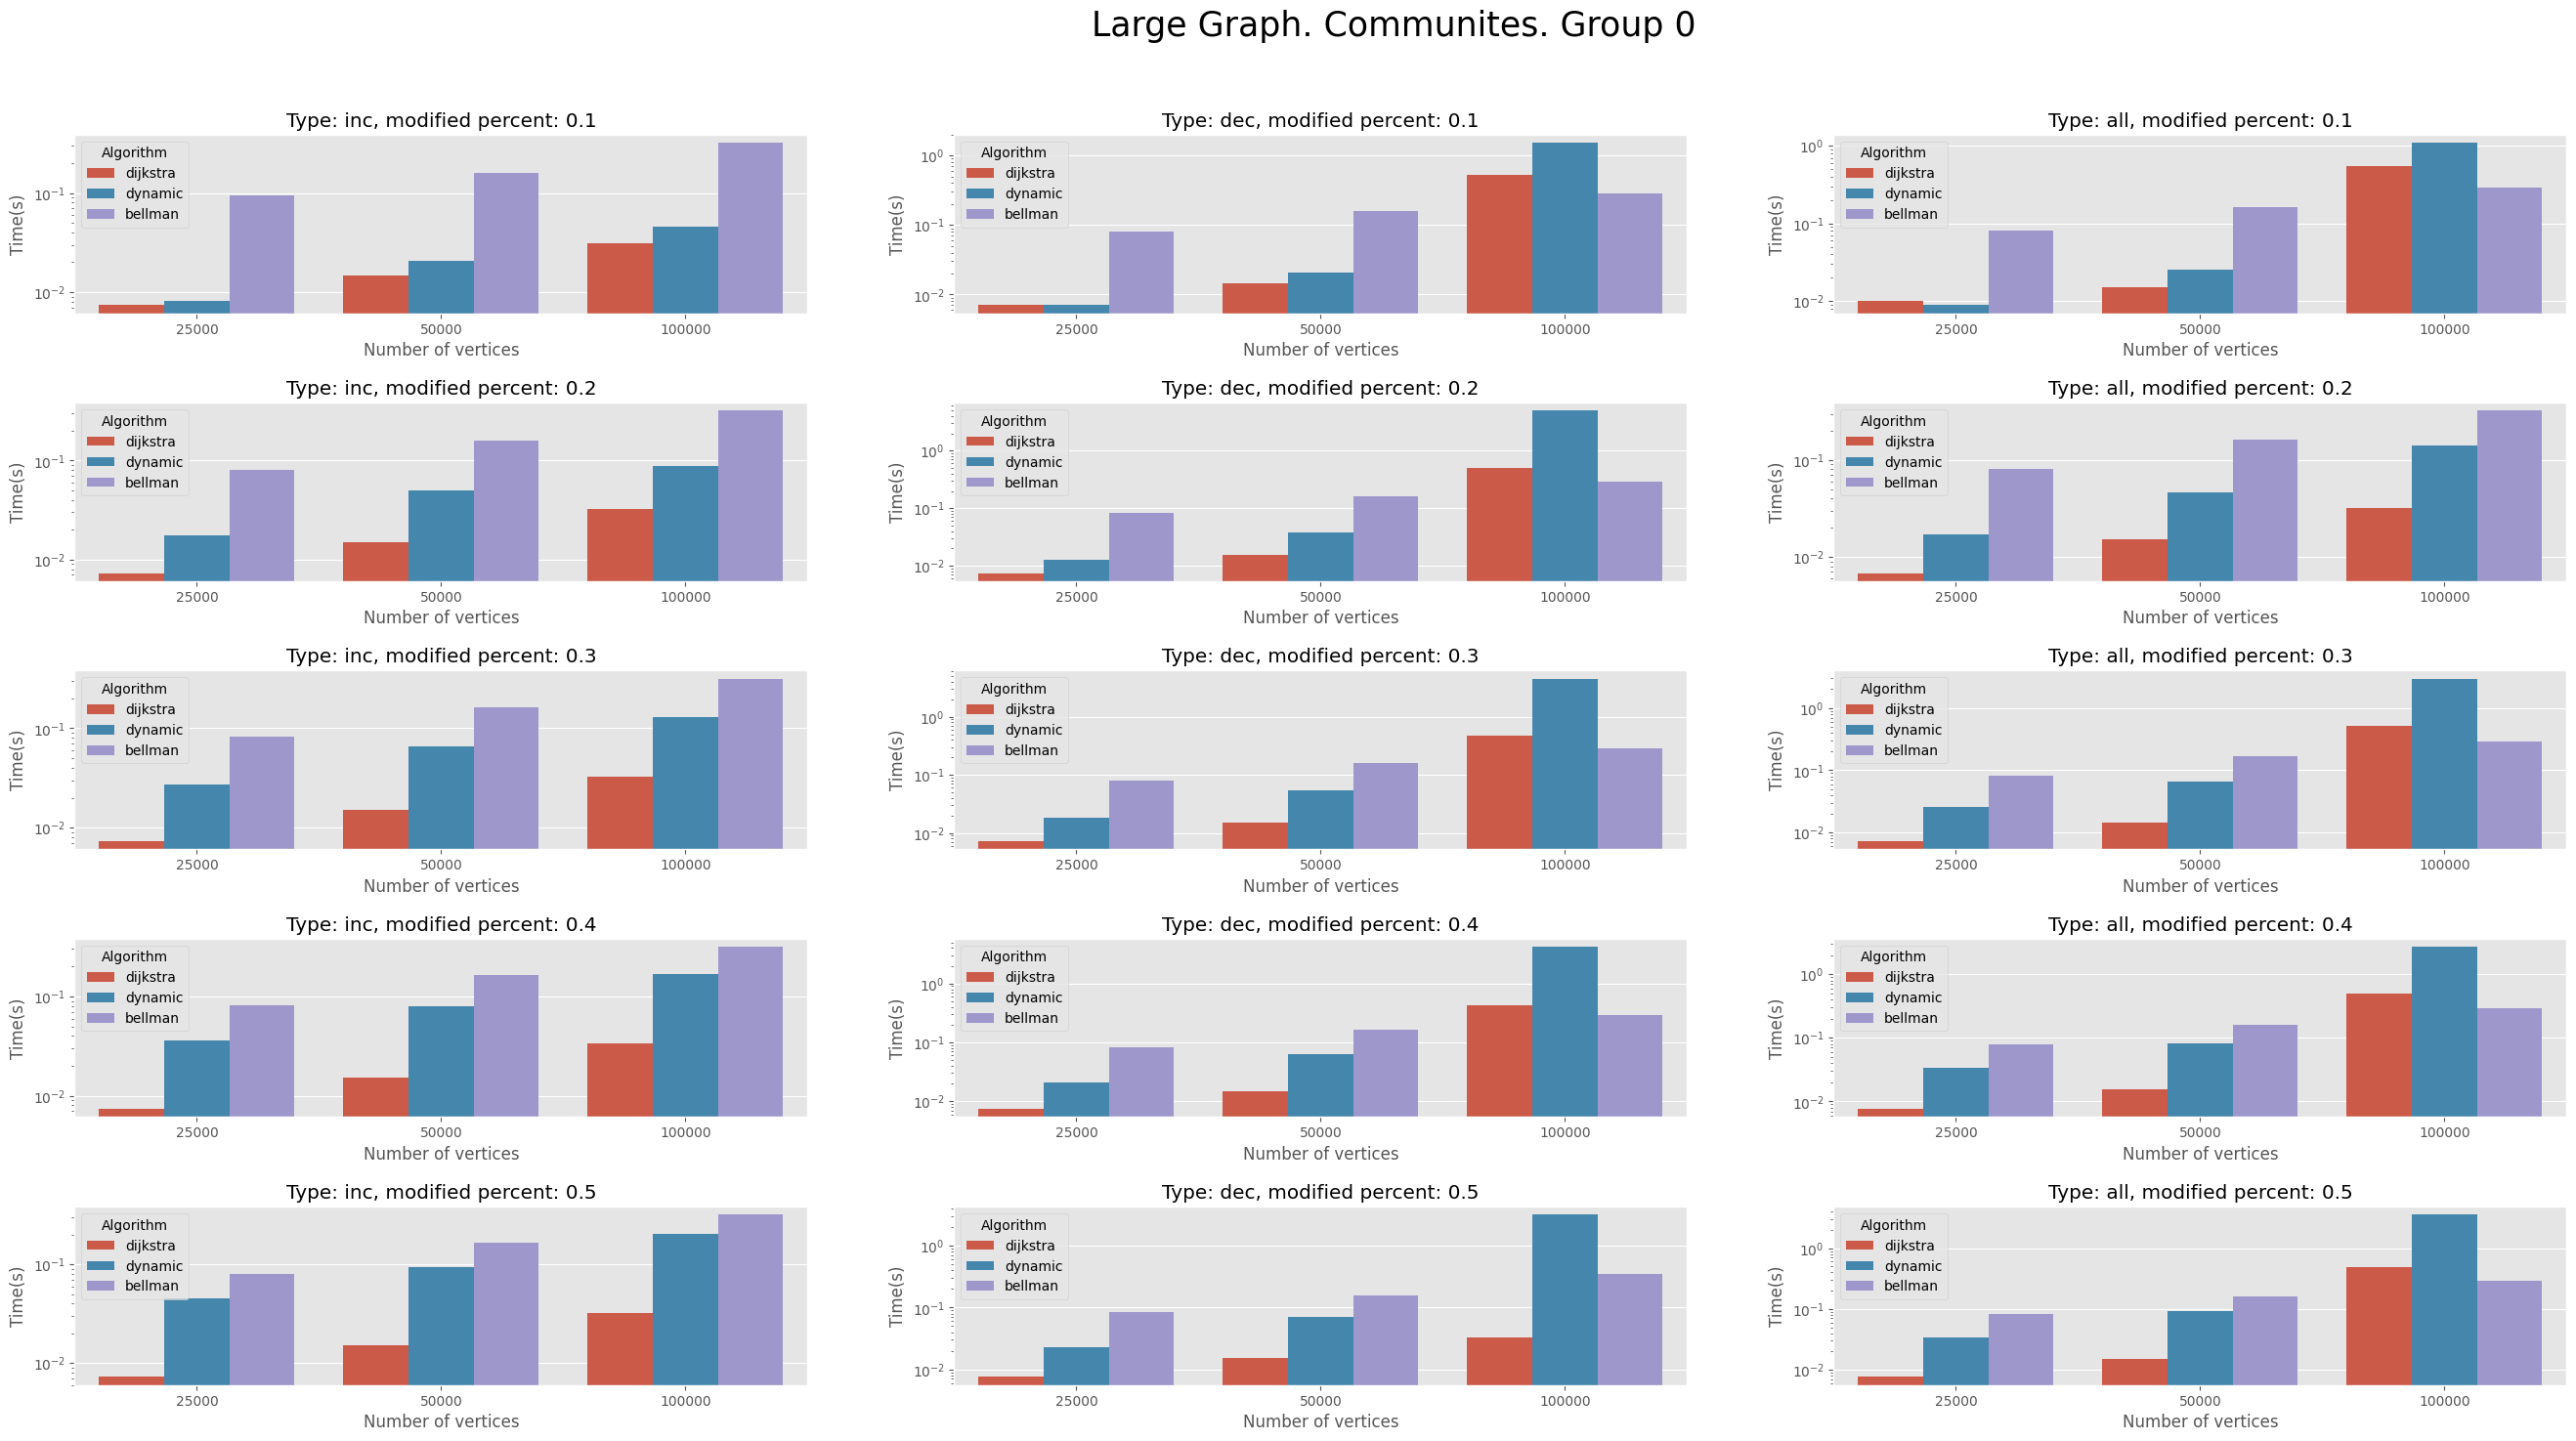

In [60]:
show_plots(large[large['Group'] == 0], "Large Graph. Communites. Group 0")

Увеличение размера сообществ (уменьшение количества сообществ) привело к замедлению алгоритмов Дейкстры на порядок в некоторых случаях при декрементальном и смешанном режимах, при этом матричный алгоритм показал ту же производительность

# Выводы
1. На маленьких графах лучше всего себя показал обычный алгоритм Дейкстры: при инкрементальном изменении графа выиграл по времени на всех рассмотренных параметрах. При смешанном и декрементальном изменении в паре случаев был медленнее динамического Дейкстры.
2. На средних графах обычный Дейкстра был быстрее при инкрементальном изменении графа, а в остальных случаях самым быстрым был матричный алгоритм.
3. На больших графах обычный Дейкстра в среднем проигрывает только при смешанном изменении графа на самом большом рассмотренном графе.
4. Увеличение размера сообществ (уменьшение количества сообществ) может приводить к существенному замедлению алгоритмов Дейкстры и матричный алгоритм будет показывать бОльшую производительность.